in this notebook, we will use the preprocessed data using approach 2 to classify eyesopen, eyesclosed using the following method

Method 1
- classify using only the following channels [27, 28, 29, 30, 57, 58, 59 ,60] these are channels related to occipital

Method 2
- Use only the Oz channel

Method 3
- all occipital channels plus P3, P4

Method 4
- all 61 channels

In [ ]:
!pip install fastai timm -Uqq

     |████████████████████████████████| 187 kB 5.3 MB/s 
     |████████████████████████████████| 431 kB 45.6 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/colab_notebooks/algovera/lynxhack

/content/drive/MyDrive/colab_notebooks/algovera/lynxhack


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import timm
from timm import create_model
from timm.models.efficientnet_blocks import DepthwiseSeparableConv
from timm.models.layers import create_conv2d
from fastai.vision.all import *

import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import pickle

In [ ]:
df = pd.read_csv('approach2infos.csv')

In [ ]:
df = df[df['label'].isin(['task-eyes closed', 'task-eyes open'])]

In [ ]:
df_train = df[df['is_valid']==False]
df_val = df[df['is_valid']==True]

In [ ]:
ss = pickle.load(open('ss_approach2.pkl', 'rb'))

In [ ]:
class InceptionBlock(nn.Module):
    def __init__(self,
        in_chs,
        out_chs,
        kernel_size,
        dropout_rate,
        activation,
        depth_multiplier=2
    ):
        super().__init__()
        
        self.conv = nn.Conv2d(in_chs,
                              out_chs,
                              kernel_size=kernel_size,
                              padding='same')

        self.bn = nn.BatchNorm2d(out_chs)
        self.act = activation()
        self.dp = nn.Dropout2d(dropout_rate)
        self.dconv = DepthwiseSeparableConv(in_chs=out_chs,
                                            out_chs=out_chs*depth_multiplier)
        self.bn2 = nn.BatchNorm2d(out_chs*depth_multiplier)
        self.act2 = activation()
        self.dp2 = nn.Dropout2d(dropout_rate)

    def forward(self, x):

        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.dp(x)
        x = self.dconv(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.dp2(x)

        return x


class EEGInception(nn.Module):
    def __init__(self,
        n_channels=61, # Num channels
        input_time=5000, # Input time
        fs=100,         # Frequence
        scales_time=(500, 250, 125), 
        dropout_rate=0.25,
        activation=nn.ELU,
        num_filters=16, 
        n_classes=5,
        block_depth_multiplier=2
    ):

        super().__init__()
        self.scales_samples = [int(s * fs / 1000) for s in scales_time]
        self.num_channels = n_channels
        self.dropout_rate = dropout_rate

        self.blocks1 = nn.ModuleList()
        for i in range(len(scales_time)):
            self.blocks1.append(InceptionBlock(
                                        in_chs=self.num_channels,
                                        out_chs=num_filters,
                                        kernel_size=(scales_time[i], 1),
                                        dropout_rate=self.dropout_rate,
                                        activation=activation,
                                        depth_multiplier=block_depth_multiplier
                                    ))

        self.avgpooling = nn.AvgPool2d(kernel_size=(4,1))

        block2_nin = num_filters*block_depth_multiplier*3
        self.blocks2 = nn.ModuleList()
        for i in range(len(scales_time)):
            self.blocks2.append(InceptionBlock(
                                        in_chs=block2_nin,
                                        out_chs=num_filters*2,
                                        kernel_size=(scales_time[i], 1),
                                        dropout_rate=self.dropout_rate,
                                        activation=activation,
                                        depth_multiplier=block_depth_multiplier
                                    ))

        self.avgpooling2 = nn.AvgPool2d(kernel_size=(4,1))

        self.conv1 = nn.Conv2d(num_filters*2*block_depth_multiplier*3, 
                               int(num_filters*len(self.scales_samples)/2),
                               kernel_size=(8, 1),
                               padding='same')
        self.bn1 = nn.BatchNorm2d(int(num_filters*len(self.scales_samples)/2))
        self.act1 = nn.ELU()
        self.avgpooling3 = nn.AvgPool2d(kernel_size=(8,1))
        self.dp1 = nn.Dropout2d(dropout_rate)

        self.conv2 = nn.Conv2d(int(num_filters*len(self.scales_samples)/2),
                               int(num_filters*len(self.scales_samples)/4),
                              kernel_size=(4, 1),
                              padding='same')
        self.bn2 = nn.BatchNorm2d(int(num_filters*len(self.scales_samples)/4))
        self.act2 = nn.ELU()
        self.avgpooling4 = nn.AvgPool2d(kernel_size=(2,1))
        self.dp2 = nn.Dropout2d(dropout_rate)

        self.flatten = nn.Flatten()
        self.final = nn.Linear(228, 5)


    def forward(self, x):
        
        block1_outs = []
        for block in self.blocks1:
            block1_outs.append(block(x))
        x = torch.cat(block1_outs, 1)
        x = self.avgpooling(x)

        block2_outs = []
        for block in self.blocks2:
            block2_outs.append(block(x))
        x = torch.cat(block2_outs, 1)
        x = self.avgpooling2(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.avgpooling3(x)
        x = self.dp1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.avgpooling4(x)
        x = self.dp2(x)

        x = self.flatten(x)
        x = self.final(x)
        return x

## Method 1 with EEGInception

In [ ]:
include = [27, 28, 29, 30, 57, 58, 59 ,60] # only channels related to occipital

def read_eeg(fn):
    include = [27, 28, 29, 30, 57, 58, 59 ,60] # only channels related to occipital
    x= np.load(fn)
    x = ss.transform(x)
    return np.expand_dims(x[include], -1)
    
def EEGBlock():
    return TransformBlock(type_tfms=read_eeg)

In [ ]:
label_index = {
    'task-eyes closed':0, 
    'task-eyes open':1,       
}

In [ ]:
dblock = DataBlock(blocks=(EEGBlock, CategoryBlock),
                   get_x=ColReader('fns'),
                   get_y=ColReader('label'),
                   splitter=ColSplitter())

dls = dblock.dataloaders(df)

In [ ]:
x,y = dls.one_batch()

In [ ]:
model = EEGInception(8)   
apply_init(model, nn.init.kaiming_normal_)

In [ ]:
learn = Learner(dls, 
                model, 
                loss_func=LabelSmoothingCrossEntropyFlat(),
                cbs=[GradientClip(),
                    # EEGCallback(),
                     SaveModelCallback(fname='chrononet')],
                metrics=accuracy
        ).to_fp16()

In [ ]:
learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.753972,5.358462,0.500000,00:59
1,1.453449,5.126885,0.586207,00:16
2,1.291452,3.181444,0.568965,00:16
3,1.147027,2.396010,0.586207,00:16
4,1.074930,1.523465,0.620690,00:16
5,1.005084,1.600876,0.655172,00:16
6,0.954265,1.010112,0.775862,00:16
7,0.906348,0.991995,0.775862,00:16
8,0.881848,0.880825,0.793103,00:16
9,0.850695,0.912089,0.810345,00:16


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:443: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


Better model found at epoch 0 with valid_loss value: 5.358462333679199.
Better model found at epoch 1 with valid_loss value: 5.126885414123535.
Better model found at epoch 2 with valid_loss value: 3.181443691253662.
Better model found at epoch 3 with valid_loss value: 2.396009922027588.
Better model found at epoch 4 with valid_loss value: 1.5234650373458862.
Better model found at epoch 6 with valid_loss value: 1.0101120471954346.
Better model found at epoch 7 with valid_loss value: 0.9919948577880859.
Better model found at epoch 8 with valid_loss value: 0.8808249831199646.
Better model found at epoch 10 with valid_loss value: 0.823137104511261.
Better model found at epoch 11 with valid_loss value: 0.7970190644264221.
Better model found at epoch 12 with valid_loss value: 0.7965559959411621.


## Method 2 with EEGInception

In [ ]:
def read_eeg(fn):
    include = [29] # only channels related to occipital
    x= np.load(fn)
    x = ss.transform(x)
    return np.expand_dims(x[include], -1)
    
def EEGBlock():
    return TransformBlock(type_tfms=read_eeg)

In [ ]:
dblock = DataBlock(blocks=(EEGBlock, CategoryBlock),
                   get_x=ColReader('fns'),
                   get_y=ColReader('label'),
                   splitter=ColSplitter())

dls = dblock.dataloaders(df)

In [ ]:
model = EEGInception(1)   
apply_init(model, nn.init.kaiming_normal_)

In [ ]:
learn = Learner(dls, 
                model, 
                loss_func=LabelSmoothingCrossEntropyFlat(),
                cbs=[GradientClip(),
                    # EEGCallback(),
                     SaveModelCallback(fname='eeginception_meth2')],
                metrics=accuracy
        ).to_fp16()

In [ ]:
learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.090497,2.896761,0.344828,00:19
1,1.759229,1.534052,0.551724,00:15
2,1.482758,0.899769,0.758621,00:15
3,1.316211,1.277419,0.551724,00:15
4,1.203846,1.617678,0.586207,00:15
5,1.118489,1.075763,0.775862,00:17
6,1.064762,0.927562,0.724138,00:17
7,1.017873,1.113739,0.655172,00:16
8,0.969006,0.927955,0.758621,00:18
9,0.924333,0.787865,0.827586,00:20


Better model found at epoch 0 with valid_loss value: 2.896761178970337.
Better model found at epoch 1 with valid_loss value: 1.534051775932312.
Better model found at epoch 2 with valid_loss value: 0.8997693061828613.
Better model found at epoch 9 with valid_loss value: 0.787865400314331.


## Method 3 EEGInception

In [ ]:
def read_eeg(fn):
    include = [24, 27, 28, 29, 30, 54, 57, 58, 59 ,60] # only channels related to occipital
    x= np.load(fn)
    x = ss.transform(x)
    return np.expand_dims(x[include], -1)
    
def EEGBlock():
    return TransformBlock(type_tfms=read_eeg)

In [ ]:
dblock = DataBlock(blocks=(EEGBlock, CategoryBlock),
                   get_x=ColReader('fns'),
                   get_y=ColReader('label'),
                   splitter=ColSplitter())

dls = dblock.dataloaders(df)

In [ ]:
model = EEGInception(10)   
apply_init(model, nn.init.kaiming_normal_)

In [ ]:
learn = Learner(dls, 
                model, 
                loss_func=LabelSmoothingCrossEntropyFlat(),
                cbs=[GradientClip(),
                    # EEGCallback(),
                     SaveModelCallback(fname='eeginception_meth3')],
                metrics=accuracy
        ).to_fp16()

In [ ]:
learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.626332,3.096744,0.500000,00:22
1,1.392290,2.458457,0.551724,00:16
2,1.194509,1.754278,0.551724,00:17
3,1.102253,1.792937,0.586207,00:16
4,1.031644,1.703764,0.603448,00:16
5,0.974299,1.655615,0.672414,00:16
6,0.933340,0.875700,0.810345,00:16
7,0.900451,0.950514,0.844828,00:16
8,0.869191,0.757754,0.844828,00:16
9,0.838504,0.769086,0.879310,00:18


Better model found at epoch 0 with valid_loss value: 3.0967438220977783.
Better model found at epoch 1 with valid_loss value: 2.458456516265869.
Better model found at epoch 2 with valid_loss value: 1.7542784214019775.
Better model found at epoch 4 with valid_loss value: 1.7037644386291504.
Better model found at epoch 5 with valid_loss value: 1.6556146144866943.
Better model found at epoch 6 with valid_loss value: 0.8757004737854004.
Better model found at epoch 8 with valid_loss value: 0.757753849029541.
Better model found at epoch 10 with valid_loss value: 0.7362073659896851.


## Method 4 EEGInception

In [ ]:
def read_eeg(fn):
    # include = [24, 27, 28, 29, 30, 54, 57, 58, 59 ,60] # only channels related to occipital
    x= np.load(fn)
    x = ss.transform(x)
    return np.expand_dims(x, -1)
    
def EEGBlock():
    return TransformBlock(type_tfms=read_eeg)

In [ ]:
dblock = DataBlock(blocks=(EEGBlock, CategoryBlock),
                   get_x=ColReader('fns'),
                   get_y=ColReader('label'),
                   splitter=ColSplitter())

dls = dblock.dataloaders(df)

In [ ]:
model = EEGInception(61)   
apply_init(model, nn.init.kaiming_normal_)

In [ ]:
learn = Learner(dls, 
                model, 
                loss_func=LabelSmoothingCrossEntropyFlat(),
                cbs=[GradientClip(),
                    # EEGCallback(),
                     SaveModelCallback(fname='eeginception_meth3')],
                metrics=accuracy
        ).to_fp16()

In [ ]:
learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.738346,4.672930,0.137931,00:45
1,1.469388,3.338705,0.500000,00:21
2,1.272768,1.978365,0.568965,00:21
3,1.138555,2.331358,0.568965,00:21
4,1.061482,1.022390,0.689655,00:21
5,1.006782,1.430091,0.672414,00:21
6,0.958861,0.938964,0.758621,00:21
7,0.910447,0.820292,0.827586,00:21
8,0.867615,0.808784,0.827586,00:21
9,0.826475,0.800829,0.810345,00:21


Better model found at epoch 0 with valid_loss value: 4.672929763793945.
Better model found at epoch 1 with valid_loss value: 3.338704824447632.
Better model found at epoch 2 with valid_loss value: 1.9783648252487183.
Better model found at epoch 4 with valid_loss value: 1.0223897695541382.
Better model found at epoch 6 with valid_loss value: 0.9389635324478149.
Better model found at epoch 7 with valid_loss value: 0.8202921152114868.
Better model found at epoch 8 with valid_loss value: 0.8087839484214783.
Better model found at epoch 9 with valid_loss value: 0.8008286952972412.
Better model found at epoch 10 with valid_loss value: 0.7953299283981323.
Better model found at epoch 11 with valid_loss value: 0.7783486843109131.
Better model found at epoch 12 with valid_loss value: 0.7781359553337097.
Better model found at epoch 13 with valid_loss value: 0.7623668909072876.
Better model found at epoch 14 with valid_loss value: 0.7502792477607727.
Better model found at epoch 17 with valid_loss v

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

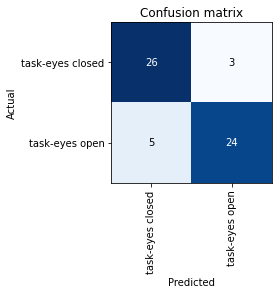

In [ ]:
interp.plot_confusion_matrix()